<a href="https://colab.research.google.com/github/EastbayML/VariationalInference/blob/main/VariationalInference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%matplotlib inline
import numpy as np
import torch
from torch import nn
from sklearn import datasets
import matplotlib.pyplot as plt
#from IPython.display import clear_output

In [2]:
def plotdist(m,X,Y):# draw samples from Q(theta)
    plt.figure(figsize=(16, 6))
    plt.scatter(X, Y)
    if m:
        with torch.no_grad():
          y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
        
        # Get some quantiles
        q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)


        plt.plot(X, mu)
        plt.fill_between(X.flatten(), q1, q2, alpha=0.2)

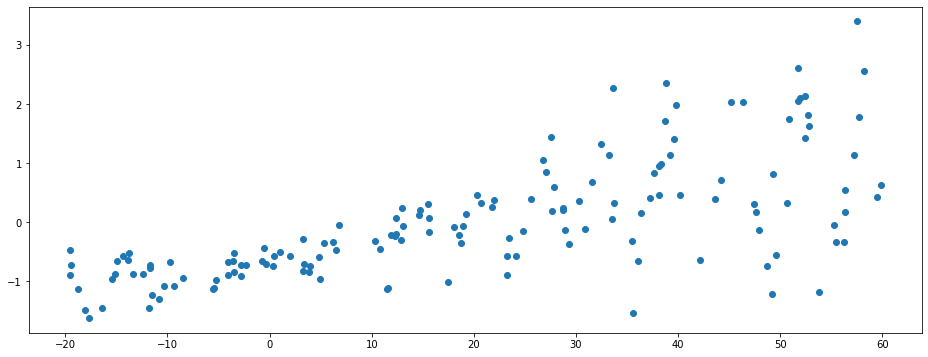

In [78]:
import numpy as np
import torch
from torch import nn
from sklearn import datasets
import matplotlib.pyplot as plt

w0 = 0.125
b0 = 5.
x_range = [-20, 60]


def load_dataset(n=150, n_tst=150):
    np.random.seed(43)
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

y, x = load_dataset()
plotdist(None,x,y)

In [4]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def reparameterize(self, mu, log_var):
        # std can not be negative, thats why we use log variance
        sigma = torch.exp(0.5 * log_var) + 1e-5
        eps = torch.randn_like(sigma)
        return mu + sigma * eps

    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var

In [5]:
def ll_gaussian(y, mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (y-mu)**2

In [23]:
def elbo(y_pred, y, mu, log_var, prior_mu, prior_log_var):
    # likelihood of observing y given Variational mu and sigma
    likelihood = ll_gaussian(y, mu, log_var)
    
    # prior probability of y_pred
    log_prior = ll_gaussian(y_pred, prior_mu, prior_log_var)
    
    # variational probability of y_pred
    log_p_q = ll_gaussian(y_pred, mu, log_var)
    
    # by taking the mean we approximate the expectation
    return (likelihood + log_prior - log_p_q).mean()

def det_loss(y_pred, y, mu, log_var, prior_mu, prior_log_var):
    return -elbo(y_pred, y, mu, log_var, prior_mu, prior_log_var)

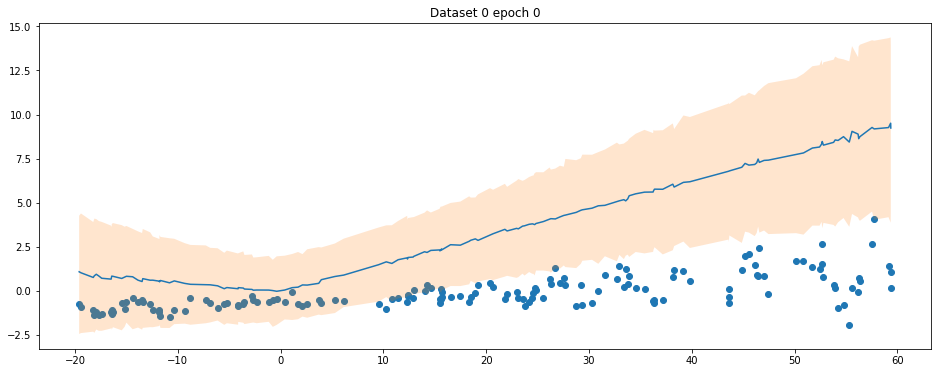

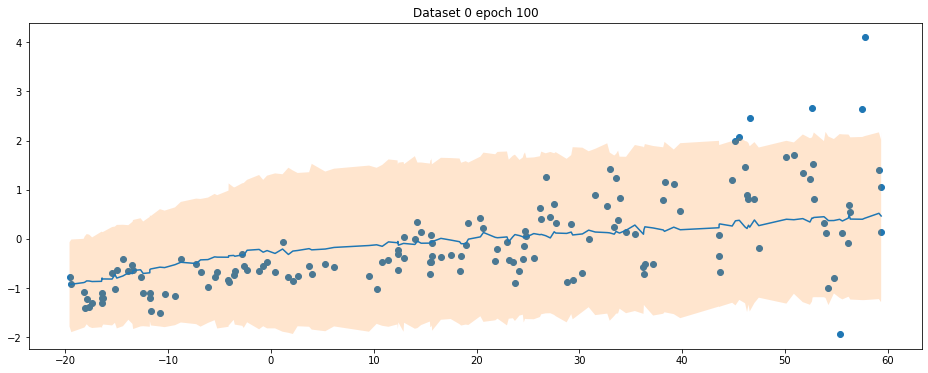

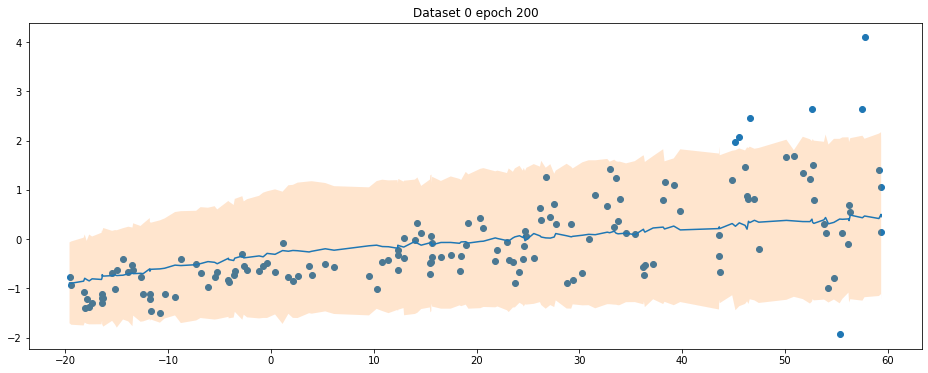

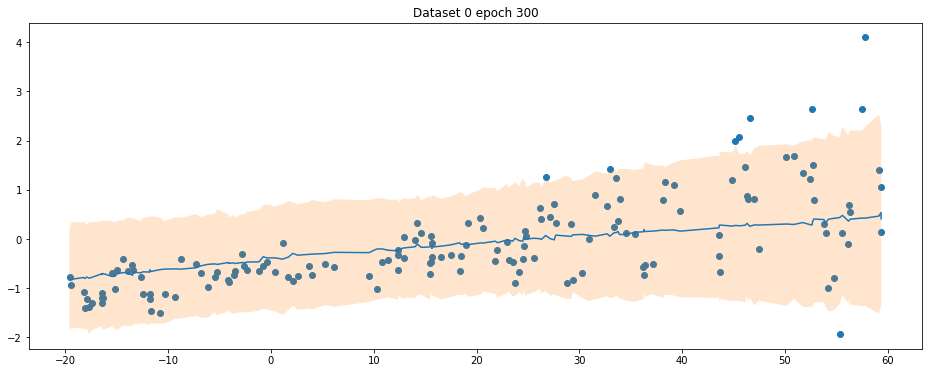

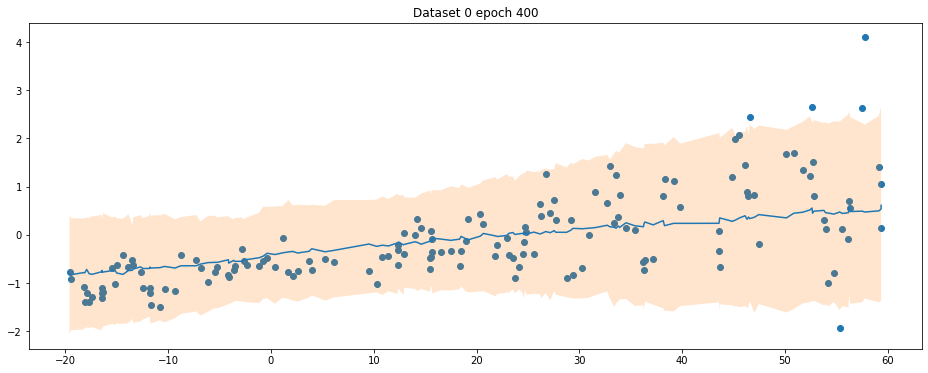

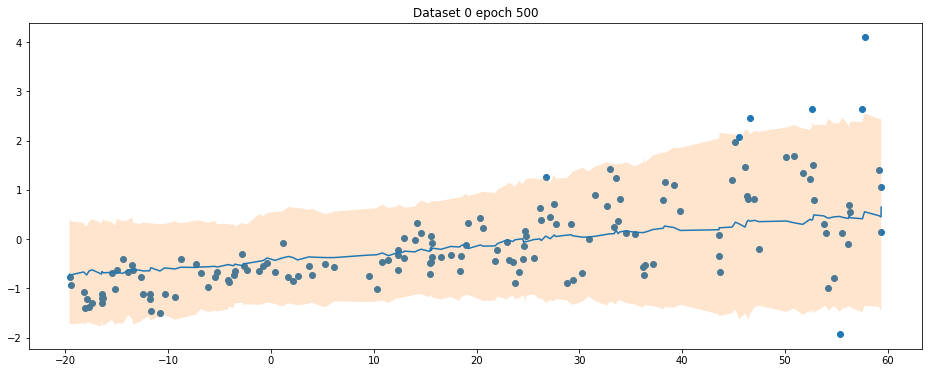

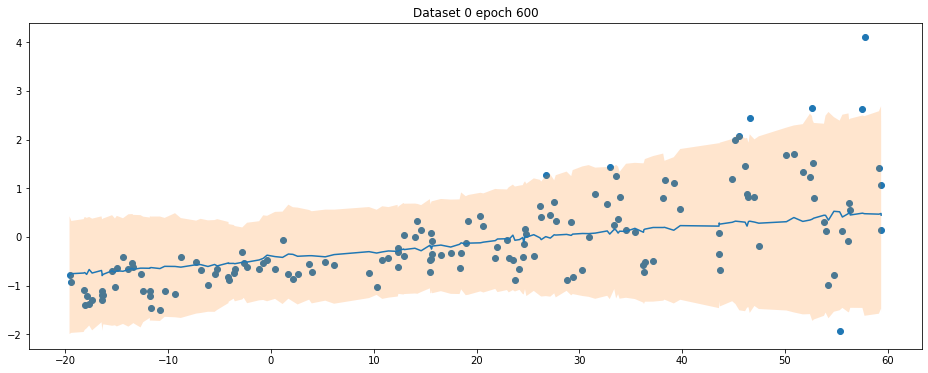

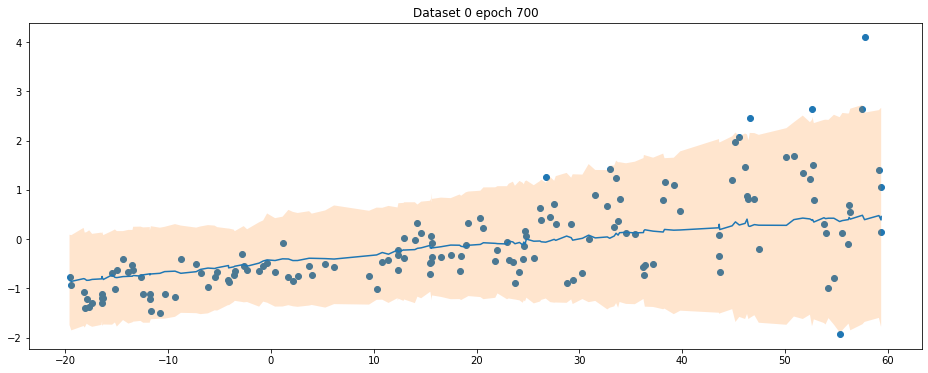

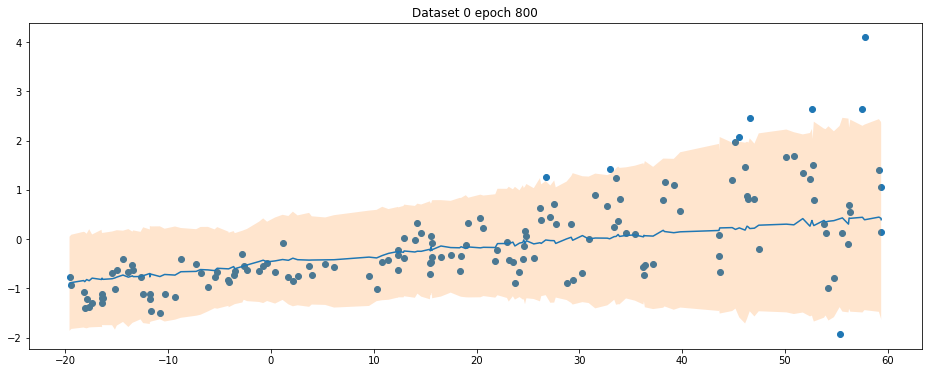

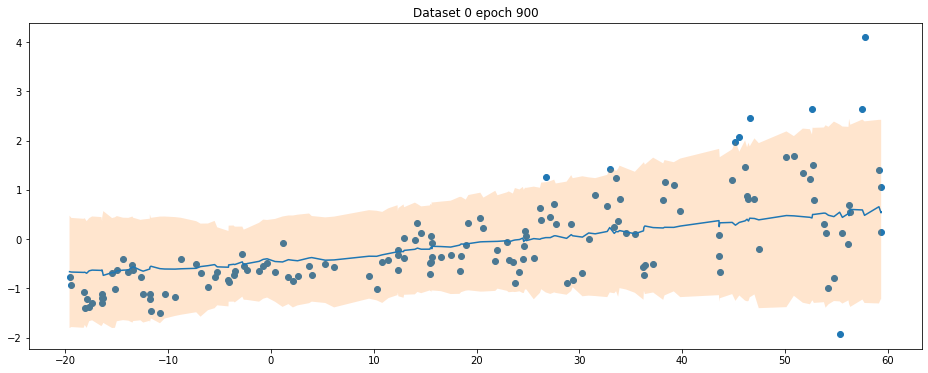

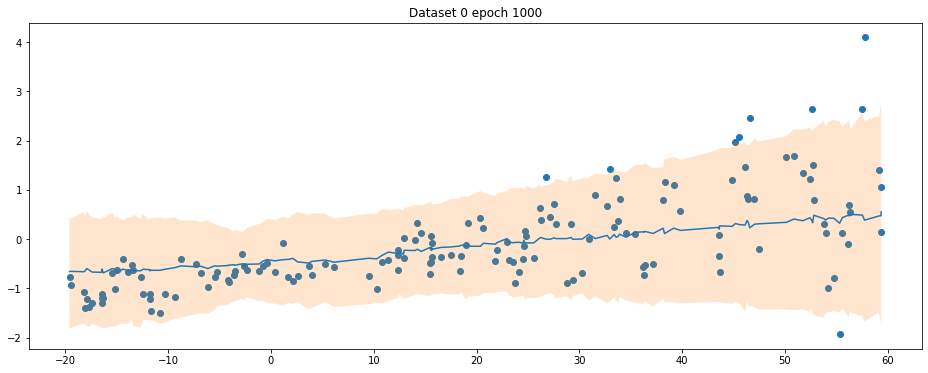

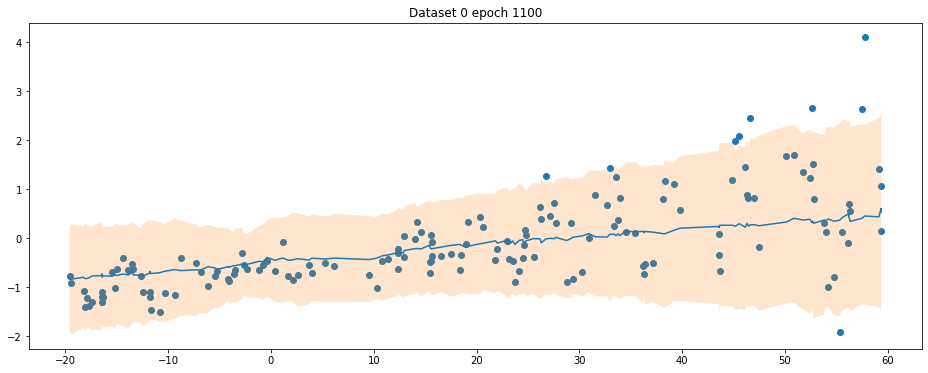

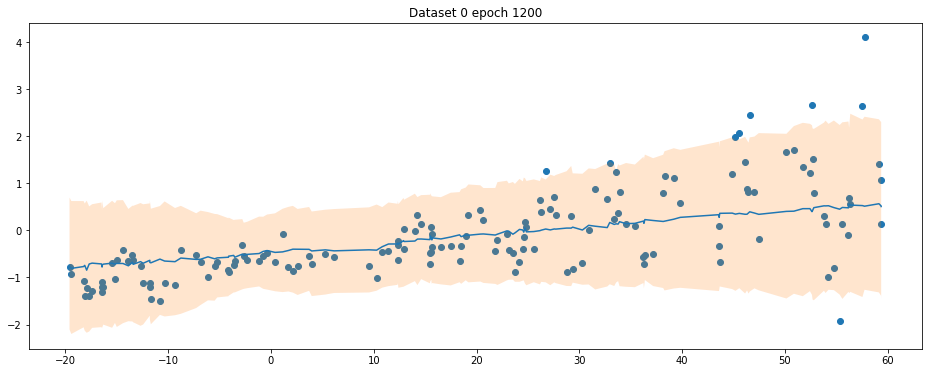

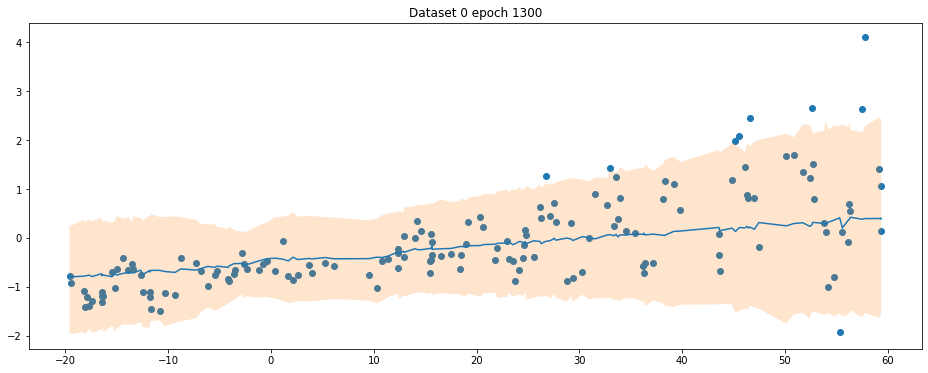

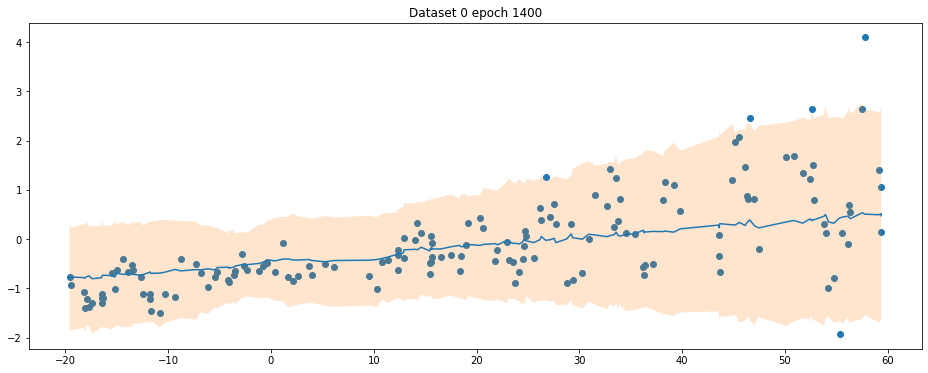

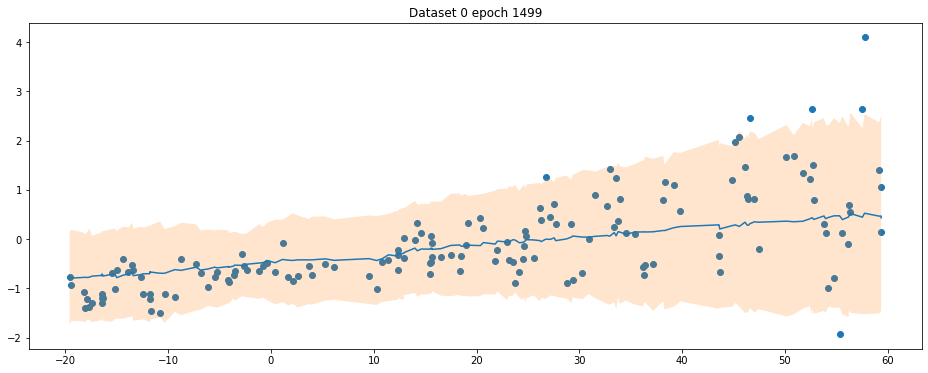

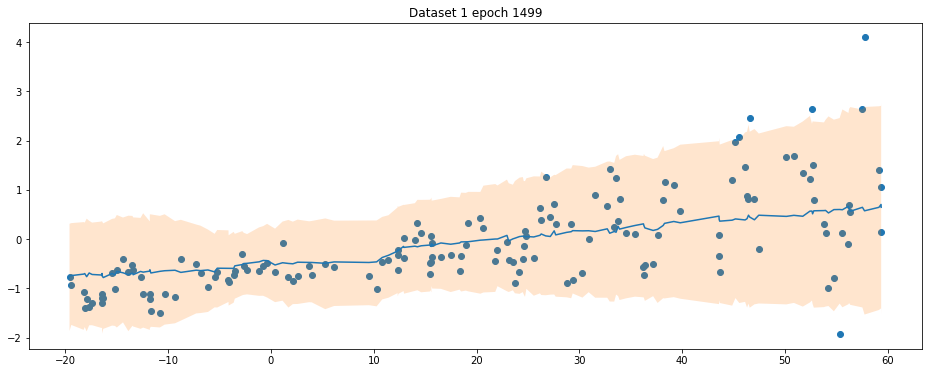

In [81]:

epochs = 1500
ndatasets=2
npoints=300
update_prior=False

m = VI()

pointsPerDataset=int(npoints/ndatasets)
y,x = load_dataset(n=npoints,n_tst=npoints)
idxs=np.random.permutation(npoints)
prior_mu,prior_log_var =  torch.tensor(0), torch.log(torch.tensor(1.))
for dataset in range(ndatasets):
  pts=np.sort(idxs[:dataset+1*pointsPerDataset]) # sorted subset of points
  X = torch.tensor(x[pts], dtype=torch.float)
  Y = torch.tensor(y[pts], dtype=torch.float)
  optim = torch.optim.Adam(m.parameters(), lr=0.005)
  for epoch in range(epochs):
      optim.zero_grad()
      y_pred, mu, log_var = m(X)
      loss = det_loss(y_pred, Y, mu, log_var, prior_mu, prior_log_var)
      loss.backward()
      optim.step()
      if (dataset == 0 and epoch % 100 == 0) or epoch == epochs -1:
        plotdist(m,X,Y)
        plt.title(f"Dataset {dataset} epoch {epoch}")
        plt.pause(0.1)
  if update_prior:
      prior_mu,prior_log_var = torch.tensor(mu.mean()), torch.tensor(log_var.mean())
